# Postpartum Depression Prediction Project

### INTRODUCTION –---

152120221051 Elif Suna GEGİN
152120211072 Resul EVLEKSİZ
152120221094 Kadriye HARMANCI

#### Project Objective  
Our project aims to build machine learning models to **predict the risk of postpartum depression (PPD)** using self-reported postnatal data. We use the variable **“Feeling anxious”** as a proxy for identifying individuals likely to experience postpartum depression, as anxiety is a common and early symptom of PPD.

#### Why It Matters?
Postpartum depression can significantly affect the well-being of both the parent and the child. Early detection using data-driven methods can enable healthcare professionals to intervene more effectively and support mental health recovery.

#### Scope of the Project  
- Predict the presence of postpartum anxiety using the **“Feeling anxious”** variable.  
- Analyze emotional, behavioral, and psychological factors collected from individuals in the postnatal period.  
- Apply and compare classification models such as Logistic Regression, Random Forest, LightGBM, CatBoost, and Stacking.  
- Address class imbalance through oversampling techniques like **SMOTE**.  
- Evaluate model performance using metrics including F1 Score, ROC-AUC, and Precision-Recall curves.

#### Dataset Information  
The dataset used in this project was sourced from **Kaggle**. It consists of self-reported responses from individuals in the postpartum period and includes approximately **1503 rows** and **11 columns**.  
The features capture a wide range of emotional and behavioral indicators such as appetite changes, sleep disturbances, guilt, bonding with the baby, and anxiety symptoms, making it suitable for mental health risk prediction.


In [1]:
# CELL 1: Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

## 2. Loading and Initial Data Inspection

* We will load the dataset from the csv file.
* Perform initial checks to understand the data structure, columns, and data types.
* Look for missing values and get a summary of the data.

---

In [ ]:
# CELL 2: Loading Dataset
print("CELL 2 Running: Loading dataset...")
df = pd.read_csv('post natal data.csv')
print("Data shape:", df.shape)

CELL 2 Running: Loading dataset...
Data shape: (1503, 11)


# 3. Target Variable Distribution and Missing Data Overview / EDA

In this step, we explore the class distribution of the target variable (`Feeling anxious`).  
This helps us understand whether the dataset is imbalanced, which is important for model evaluation.  
We also visualize the location of missing values in the dataset using a heatmap to identify which columns require imputation.


Target variable distribution:
Feeling anxious
Yes    980
No     523
Name: count, dtype: int64


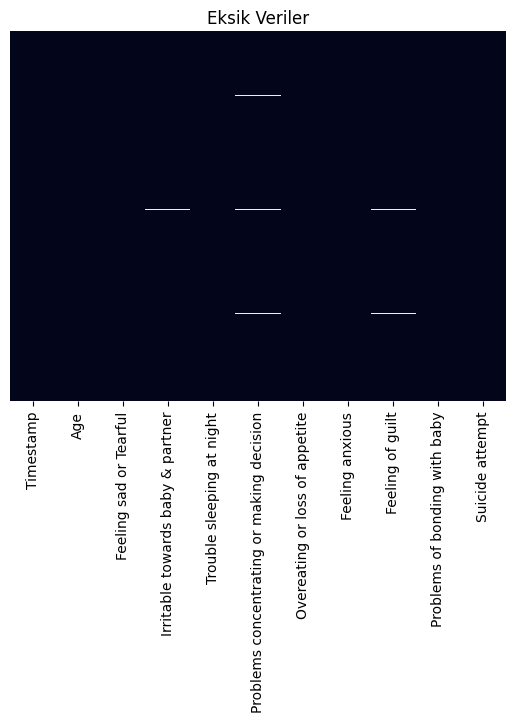

In [23]:
print("Target variable distribution:")
print(df['Feeling anxious'].value_counts())

sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Eksik Veriler")
plt.show()


### 3.1 Feature-Target Relationship: Overeating vs Feeling Anxious

This plot shows how the presence of overeating or appetite loss relates to anxiety symptoms.


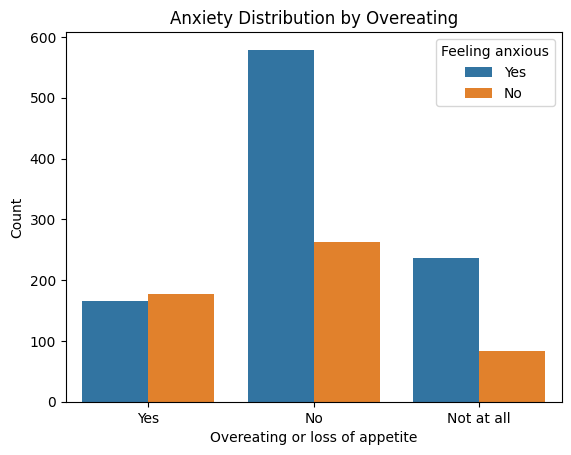

In [24]:
sns.countplot(x='Overeating or loss of appetite', hue='Feeling anxious', data=df)
plt.title("Anxiety Distribution by Overeating")
plt.xlabel("Overeating or loss of appetite")
plt.ylabel("Count")
plt.show()


### 3.2 Missing Data Percentage Overview

In addition to the missing value heatmap, this step provides a precise percentage of missing values in each feature.  
Understanding the extent of missing data helps in choosing the right imputation strategy.


Missing Data (%):
Problems concentrating or making decision    0.798403
Feeling of guilt                             0.598802
Irritable towards baby & partner             0.399202
dtype: float64


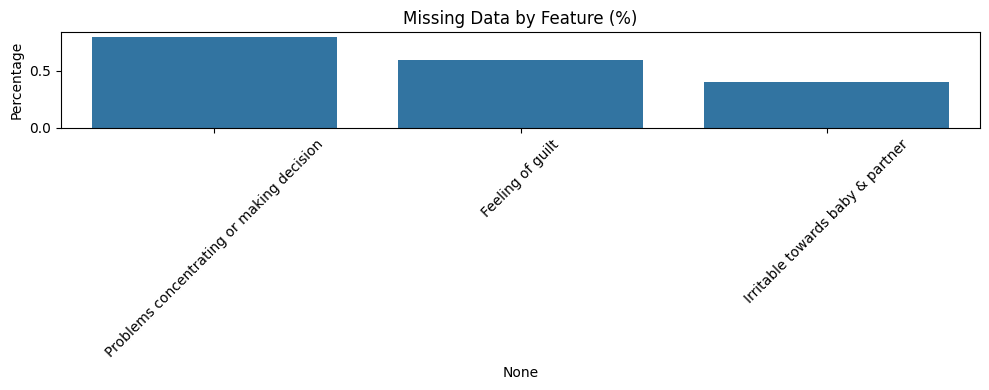

In [25]:
# CELL 3.2: Missing Data Percentage Summary

# Calculate percentage of missing values in each column
missing_percentages = df.isnull().mean().sort_values(ascending=False) * 100
missing_percentages = missing_percentages[missing_percentages > 0]

# Display missing data percentages
print("Missing Data (%):")
print(missing_percentages)

# Visualize missing data percentages
plt.figure(figsize=(10, 4))
sns.barplot(x=missing_percentages.index, y=missing_percentages.values)
plt.title("Missing Data by Feature (%)")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 4. Initial Data Cleaning and Ambiguous Value Handling

Some responses in the dataset contain vague or non-standard answers such as "Maybe", "Often", or "Not interested to say".  
These values are not informative and may hinder the modeling process.  
To address this, we replace them with `NaN` values so they can be handled systematically in the imputation step that follows.


In [26]:
# CELL 3: Initial Inspection & Preprocessing
# Belirsiz kategorileri NaN ile değiştiriyoruz
df.replace({
    "Feeling of guilt": {"Maybe": np.nan},
    "Problems concentrating or making decision": {"Often": np.nan},
    "Suicide attempt": {"Not interested to say": np.nan}
}, inplace=True)

print("CELL 3 Running: Preprocessing...")


CELL 3 Running: Preprocessing...


### 4.1 Encoding Strategy

To prepare the data for machine learning algorithms, we apply:
- Ordinal encoding for age ranges.
- Label encoding for binary and ordinal features.
- One-hot encoding for nominal features that are non-ordinal and have multiple categories.


In [27]:
# CELL 4: Handling Missing Values and Encoding
print("CELL 4 Running: Handling Missing Values and Encoding...")
# Belirsiz cevaplardan kaynaklı eksik değerleri en sık görülenle doldur
cols_to_impute = [
    "Irritable towards baby & partner",
    "Problems concentrating or making decision",
    "Feeling of guilt"
]
imp = SimpleImputer(strategy='most_frequent')
df[cols_to_impute] = imp.fit_transform(df[cols_to_impute])


# Encode categorical data
feature_columns = [
    'Irritable towards baby & partner',
    'Problems of bonding with baby',
    'Suicide attempt',
    'Overeating or loss of appetite'
]
X = df[feature_columns]
y = df["Feeling anxious"]

# One-hot encoding ile kategorik verileri dönüştür
X_encoded = pd.get_dummies(X, drop_first=True)


le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

CELL 4 Running: Handling Missing Values and Encoding...


### 6. Correlation Matrix Between Selected Features and Target Variable

In this step, we calculate and visualize the **correlation matrix** between selected features and the target variable (`Feeling anxious`):

- The target column is temporarily added back to the feature set.
- Categorical variables are converted to numerical format using `pd.factorize()`, ensuring compatibility with correlation calculations.
- A heatmap is generated to show the linear correlation between all variables.

> This helps identify potential multicollinearity between features and shows how strongly each variable is related to the target.


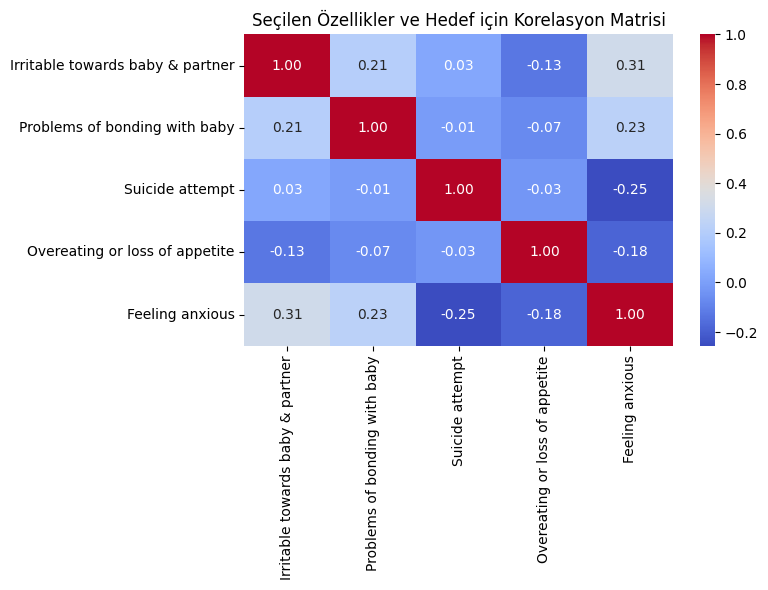

In [28]:
# Seçilen feature ve hedef sütunları birleştir
corr_df = X.copy()
corr_df['Feeling anxious'] = y

# Kategorik değişkenleri sayısala çevir (gerekirse)
corr_df_encoded = corr_df.apply(lambda col: pd.factorize(col)[0] if col.dtype == 'object' else col)

# Korelasyon matrisi
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Seçilen Özellikler ve Hedef için Korelasyon Matrisi")
plt.tight_layout()
plt.show()

### 7. Train-Test Split and Preprocessing

The dataset is split into training and testing sets with stratification to preserve class balance.  
Then, StandardScaler is applied using a ColumnTransformer to normalize the features before training.

In [29]:
# CELL 4.5: Train/Test Split & Preprocessor (Son Hali)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_features = X_encoded.columns # Tüm sütunlar sayısal kabul ediliyor

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("CELL 4.5 Running: Preprocessor created. Train/test split is handled by K-Fold Cross-Validation.")

CELL 4.5 Running: Preprocessor created. Train/test split is handled by K-Fold Cross-Validation.


### 8. Final Data Type Check and Boolean Conversion

Before model training, we ensure that all features are in a compatible numeric format.

- Boolean values, if any, are explicitly converted to integers (`True` → 1, `False` → 0).
- A data type check is performed on the training dataset to verify that all features are numeric.

> This is a safety step to avoid type-related issues during model training or pipeline transformations.


In [30]:
from sklearn.preprocessing import FunctionTransformer

# Boolean varsa int'e çevir
X_train = X_train.applymap(lambda x: int(x) if isinstance(x, (bool, np.bool_)) else x)

# Son kontroller
print(X_train.dtypes.value_counts())


int64    7
Name: count, dtype: int64


### 9. Training and Evaluating Models Without SMOTE

In this step, we train all models on the original dataset **without applying any resampling** technique like SMOTE.  
This provides a baseline to compare with the SMOTE-enhanced results later.

Key points:
- A new train-test split is performed on the original encoded dataset.
- A consistent pipeline is used for each model, including preprocessing.
- The following metrics are calculated:
  - Accuracy
  - F1 Score
  - ROC AUC

> This baseline evaluation helps quantify the impact of data imbalance on model performance.


In [31]:
# CELL 11: Train and Evaluate Models WITHOUT SMOTE
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbosity=-1),
    "StackingClassifier": StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=42)),
            ('dt', DecisionTreeClassifier(random_state=42)),
            ('lr', LogisticRegression(max_iter=1000, solver='liblinear'))
        ],
        final_estimator=LogisticRegression()
    )
}

try:
    from catboost import CatBoostClassifier
    models["CatBoost (manual)"] = CatBoostClassifier(verbose=0, random_state=42)
except:
    pass
print("CELL 11 Running: Training models without SMOTE...")

results_nosmote = {}

X_no = X_encoded.copy()
y_no = y_encoded.copy()

# Veri tekrar bölünüyor (SMOTE uygulanmadan önceki haliyle)
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(X_no, y_no, test_size=0.2, random_state=42, stratify=y_no)

for name, model in models.items():
    if name == "CatBoost (manual)":
        model.fit(X_train_no, y_train_no)
        y_pred = model.predict(X_test_no)
        y_proba = model.predict_proba(X_test_no)[:, 1]
    else:
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        pipe.fit(X_train_no, y_train_no)
        y_pred = pipe.predict(X_test_no)
        y_proba = pipe.predict_proba(X_test_no)[:, 1]

    results_nosmote[name] = {
        "Accuracy": accuracy_score(y_test_no, y_pred),
        "F1 Score": f1_score(y_test_no, y_pred),
        "ROC AUC": roc_auc_score(y_test_no, y_proba)
    }


CELL 11 Running: Training models without SMOTE...


### 9.1. ROC Curve Comparison (Without SMOTE)

This additional plot illustrates how models perform **without any class balancing**.  
Since the training data is imbalanced, many models may struggle to correctly identify the minority class.

- AUC scores are generally lower compared to SMOTE-enhanced training.
- This serves as a **baseline** to demonstrate the impact of class imbalance.

> Conclusion: Balancing the training data significantly improves model discrimination ability.


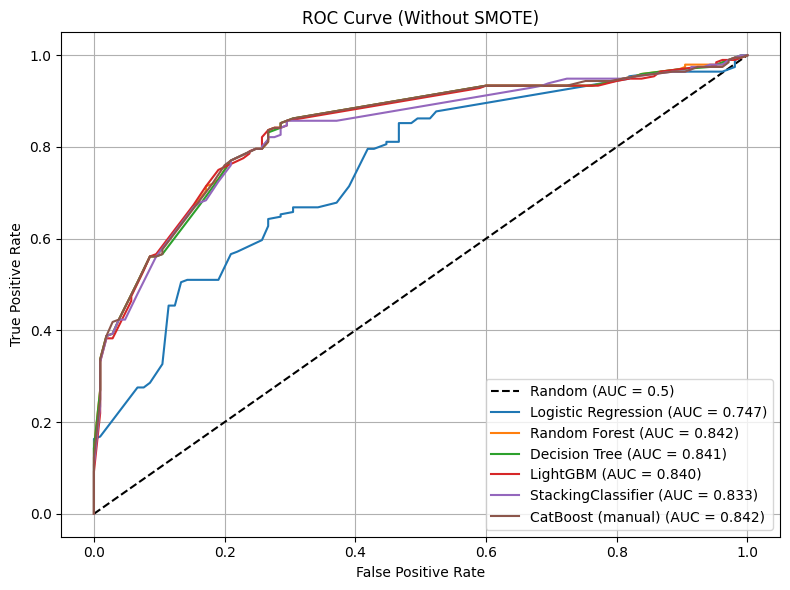

In [32]:
# CELL 9.5: ROC Curves Without SMOTE

from sklearn.metrics import roc_curve, auc

# Re-create models dictionary if it was overwritten
model_dict = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbosity=-1),
    "StackingClassifier": StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=42)),
            ('dt', DecisionTreeClassifier(random_state=42)),
            ('lr', LogisticRegression(max_iter=1000, solver='liblinear'))
        ],
        final_estimator=LogisticRegression()
    )
}

try:
    from catboost import CatBoostClassifier
    model_dict["CatBoost (manual)"] = CatBoostClassifier(verbose=0, random_state=42)
except:
    pass

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

for name, model in model_dict.items():
    if name == "CatBoost (manual)":
        model.fit(X_train_no, y_train_no)
        y_proba = model.predict_proba(X_test_no)[:, 1]
    else:
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
        pipe.fit(X_train_no, y_train_no)
        y_proba = pipe.predict_proba(X_test_no)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test_no, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Without SMOTE)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


### 10. Class Distribution Before SMOTE

This bar chart visualizes the distribution of the target variable (`Feeling anxious`) before applying SMOTE.  
It highlights the **class imbalance** problem, which can negatively affect model performance by biasing predictions toward the majority class.

> This imbalance is the main reason why SMOTE will be applied later to balance the training data.


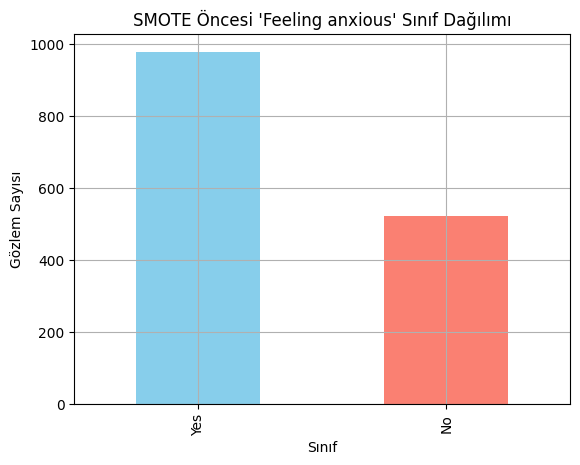

In [33]:
# SMOTE öncesi sınıf dağılımı
df["Feeling anxious"].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("SMOTE Öncesi 'Feeling anxious' Sınıf Dağılımı")
plt.ylabel("Gözlem Sayısı")
plt.xlabel("Sınıf")
plt.grid(True)
plt.show()

### 11. Confusion Matrix Visualization

The confusion matrix provides a detailed view of classification results:

- **True Positives (TP):** Correctly predicted positive cases  
- **True Negatives (TN):** Correctly predicted negative cases  
- **False Positives (FP):** Incorrectly predicted as positive  
- **False Negatives (FN):** Incorrectly predicted as negative

> This visualization helps interpret the model’s strengths and weaknesses in classification, especially for imbalanced datasets.


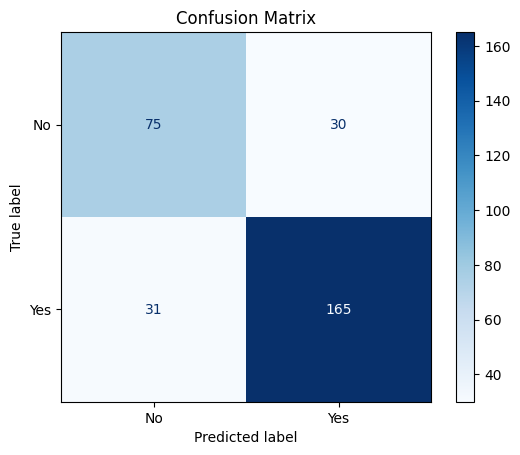

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No", "Yes"], cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


### 12. Balancing the Dataset with SMOTE

In this step, we apply **SMOTE (Synthetic Minority Over-sampling Technique)** to the training data only.

- SMOTE creates synthetic samples of the minority class by interpolating between existing observations.
- This helps reduce bias in the classifier toward the majority class.
- The new class distribution is printed after resampling.

> ⚠️ Note: SMOTE is applied only to the training data to avoid data leakage during validation or testing.


In [35]:
# CELL 5: Balancing the Dataset with SMOTE
print("CELL 5 Running: Applying SMOTE to training data only...")

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After SMOTE - Class distribution:")
print(pd.Series(y_train).value_counts())


CELL 5 Running: Applying SMOTE to training data only...
After SMOTE - Class distribution:
0    784
1    784
Name: count, dtype: int64


### 13. Defining Classification Models

In this step, we define a dictionary of classifiers that will be used in model evaluation.  
The models include a mix of simple, ensemble, and boosting-based algorithms:

- **Logistic Regression** — A linear baseline classifier.  
- **Decision Tree** — A non-linear tree-based model.  
- **Random Forest** — An ensemble method using bagging.  
- **LightGBM** — A fast and efficient gradient boosting method.  
- **CatBoost** — A boosting algorithm particularly effective with categorical data.  
- **StackingClassifier** — A meta-model that combines multiple classifiers for improved performance.

We also initialize:
- `roc_curves_data`: stores false positive/true positive values for ROC plots.  
- `model_predictions`: stores test labels and predicted probabilities for Precision-Recall analysis.

> These models will later be evaluated using stratified cross-validation.


In [36]:
# CELL 6: Define Models
print("CELL 6 Running: Defining models...")
import numpy as np # Bu satırı da eklemek iyi bir pratik, bazı modellerin iç parametreleri için gerekebilir.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Define base estimators for StackingClassifier
estimators = [
    ('lr', LogisticRegression(random_state=42, solver='liblinear')), # solver='liblinear' added for compatibility
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
]

# Define models dictionary with unfitted models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "StackingClassifier": StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42, solver='liblinear'), cv=5),
    "CatBoost (manual)": CatBoostClassifier(random_state=42, verbose=0) # verbose=0 to suppress output during training
}

# Sonuçları, ROC eğrisi verilerini ve tahminleri depolamak için sözlükler
results = {} # Bu artık kullanılmıyor, yerine cv_results kullanılacak.
roc_curves_data = {} # ROC eğrisi verileri (K-Fold ile birleştirilmiş)
model_predictions = {} # ADDED: K-Fold tahminlerini depolamak için sözlük (y_test ve y_proba)

CELL 6 Running: Defining models...


### 14. Training and Evaluating Models with SMOTE and Stratified K-Fold Cross-Validation

This step performs model training and evaluation using **Stratified K-Fold Cross-Validation (5 folds)** on a dataset that is balanced using **SMOTE**.

Key details:
- Each fold maintains class distribution (`StratifiedKFold`).
- **SMOTE is applied only to the training fold**, ensuring no data leakage.
- A pipeline is used for each model (except CatBoost), which includes preprocessing and classification.
- The following evaluation metrics are calculated per fold and then averaged:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
  - ROC AUC
- ROC and Precision-Recall data are also stored for each model for visualization.

> This approach ensures a fair and robust evaluation of each model on balanced data.


In [37]:
# CELL 7: Train and Evaluate Models (K-Fold Cross-Validation ile Son Hali)
print("CELL 7 Running: Training and evaluating models with K-Fold Cross-Validation...")

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE # SMOTE kütüphanesinin yüklü olduğundan emin olun (pip install imbalanced-learn)

# K-Fold Cross-Validation ayarları
n_splits = 5 # Kaç katmana bölüneceği (genellikle 5 veya 10)
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) # Sınıf dengesini korur ve karıştırır

# SMOTE objesi
smote = SMOTE(random_state=42)

# Çapraz doğrulama sonuçlarını depolamak için sözlük
cv_results = {}

# ROC ve P-R eğrileri için verileri depolamak için sözlükler (Cell 6'da tanımlanmış olmalı)
# roc_curves_data = {}
# model_predictions = {}

for name, model in models.items():
    print(f"\nEvaluating {name} with {n_splits}-Fold Cross-Validation...")
    
    # Her metrik için tüm katmanlardaki sonuçları depolamak için listeler
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    fold_roc_aucs = []
    
    # ROC ve P-R eğrilerini çizmek için tüm katmanlardaki y_true ve y_proba değerlerini birleştireceğiz
    all_y_val_true_for_plot = []
    all_y_val_proba_for_plot = []

    # Her bir katman üzerinde döngü
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X_encoded, y_encoded)):
        print(f"  Fold {fold_idx + 1}/{n_splits}...")
        
        # Veri setini eğitim ve doğrulama katmanlarına böl
        # X_encoded bir DataFrame olduğu için .iloc kullanmaya devam edebiliriz
        X_train_fold, X_val_fold = X_encoded.iloc[train_index], X_encoded.iloc[val_index]
        # y_encoded bir NumPy dizisi olduğu için doğrudan indeksleme kullanırız
        y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

        X_train_fold = pd.DataFrame(X_train_fold).astype(float)
        # SMOTE'u SADECE eğitim katmanına uygula
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        if name == "CatBoost (manual)":
            # CatBoost'ı doğrudan eğit (preprocessor olmadan)
            model.fit(X_train_resampled, y_train_resampled)
            y_pred_fold = model.predict(X_val_fold)
            y_proba_fold = model.predict_proba(X_val_fold)[:, 1]
        else:
            # Diğer modeller için Pipeline oluştur ve eğit
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor), # preprocessor CELL 4.5'te tanımlandı
                ('classifier', model)
            ])
            pipeline.fit(X_train_resampled, y_train_resampled)
            y_pred_fold = pipeline.predict(X_val_fold)
            y_proba_fold = pipeline.predict_proba(X_val_fold)[:, 1]

        # Bu katman için metrikleri hesapla ve depola
        fold_accuracies.append(accuracy_score(y_val_fold, y_pred_fold))
        fold_precisions.append(precision_score(y_val_fold, y_pred_fold, zero_division=0))
        fold_recalls.append(recall_score(y_val_fold, y_pred_fold, zero_division=0))
        fold_f1_scores.append(f1_score(y_val_fold, y_pred_fold, zero_division=0))
        fold_roc_aucs.append(roc_auc_score(y_val_fold, y_proba_fold))
        
        # ROC ve P-R eğrileri için tahminleri topla
        all_y_val_true_for_plot.extend(y_val_fold)
        all_y_val_proba_for_plot.extend(y_proba_fold)

    # Modelin çapraz doğrulama ortalama ve standart sapma sonuçlarını kaydet
    cv_results[name] = {
        "Accuracy_Mean": np.mean(fold_accuracies),
        "Accuracy_Std": np.std(fold_accuracies),
        "Precision_Mean": np.mean(fold_precisions),
        "Precision_Std": np.std(fold_precisions),
        "Recall_Mean": np.mean(fold_recalls),
        "Recall_Std": np.std(fold_recalls),
        "F1_Score_Mean": np.mean(fold_f1_scores),
        "F1_Score_Std": np.std(fold_f1_scores),
        "ROC_AUC_Mean": np.mean(fold_roc_aucs),
        "ROC_AUC_Std": np.std(fold_roc_aucs)
    }
    
    # ROC eğrisi için (tüm katmanların birleştirilmiş verileriyle)
    fpr, tpr, _ = roc_curve(all_y_val_true_for_plot, all_y_val_proba_for_plot)
    roc_curves_data[name] = (fpr, tpr, np.mean(fold_roc_aucs)) # Ortalama AUC ile eğri

    # P-R eğrisi için (tüm katmanların birleştirilmiş verileriyle)
    model_predictions[name] = {
        'y_test': np.array(all_y_val_true_for_plot),
        'y_proba': np.array(all_y_val_proba_for_plot)
    }

print("\nAll models evaluated with K-Fold Cross-Validation.")

CELL 7 Running: Training and evaluating models with K-Fold Cross-Validation...

Evaluating Logistic Regression with 5-Fold Cross-Validation...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Evaluating Random Forest with 5-Fold Cross-Validation...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Evaluating Decision Tree with 5-Fold Cross-Validation...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Evaluating LightGBM with 5-Fold Cross-Validation...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Evaluating StackingClassifier with 5-Fold Cross-Validation...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Evaluating CatBoost (manual) with 5-Fold Cross-Validation...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

All models evaluated with K-Fold Cross-Validation.


### 15. Displaying Cross-Validation Results (After SMOTE)

This step displays the evaluation results obtained from cross-validation after applying SMOTE.

- The `cv_results` dictionary is converted into a DataFrame.
- Each model is represented as a row, and the evaluation metrics (mean and standard deviation) as columns.
- The results are rounded to 3 decimal places for better readability.

> This comparative table allows for quick assessment of model performance across multiple metrics.


In [38]:
# CELL 8: Display Results (Son Hali)
print("CELL 8 Running: Displaying Cross-Validation Results...")
import pandas as pd
# NumPy zaten Cell 6 veya Cell 7'de import edilmiş olmalı, ama emin olmak için buraya da ekleyebiliriz.
# import numpy as np

# cv_results sözlüğünü DataFrame'e dönüştür ve transpoze et (modelleri satırda görmek için)
results_df = pd.DataFrame(cv_results).T
results_df = results_df.round(3) # Sonuçları 3 ondalık basamağa yuvarla

print(results_df)

CELL 8 Running: Displaying Cross-Validation Results...
                     Accuracy_Mean  Accuracy_Std  Precision_Mean  \
Logistic Regression          0.701         0.035           0.806   
Random Forest                0.776         0.022           0.859   
Decision Tree                0.773         0.022           0.862   
LightGBM                     0.770         0.022           0.859   
StackingClassifier           0.776         0.022           0.854   
CatBoost (manual)            0.778         0.025           0.857   

                     Precision_Std  Recall_Mean  Recall_Std  F1_Score_Mean  \
Logistic Regression          0.034        0.712       0.027          0.756   
Random Forest                0.018        0.785       0.023          0.820   
Decision Tree                0.019        0.777       0.025          0.817   
LightGBM                     0.018        0.776       0.026          0.815   
StackingClassifier           0.015        0.791       0.029          0.821   


### 16. Plotting ROC and Precision-Recall Curves

This step visualizes model performance using two key evaluation curves:

####  Left: ROC Curve (Receiver Operating Characteristic)
- Shows the trade-off between **True Positive Rate** and **False Positive Rate**.
- AUC (Area Under Curve) indicates classifier performance (closer to 1.0 is better).

####  Right: Precision-Recall Curve
- Focuses on performance under **class imbalance**.
- Shows the trade-off between **precision** (positive predictive value) and **recall** (sensitivity).
- Baseline reflects the proportion of the positive class in the dataset.

> These visualizations provide an intuitive understanding of model effectiveness across all thresholds.



CELL 9 Running: Plotting ROC and Precision-Recall Curves...


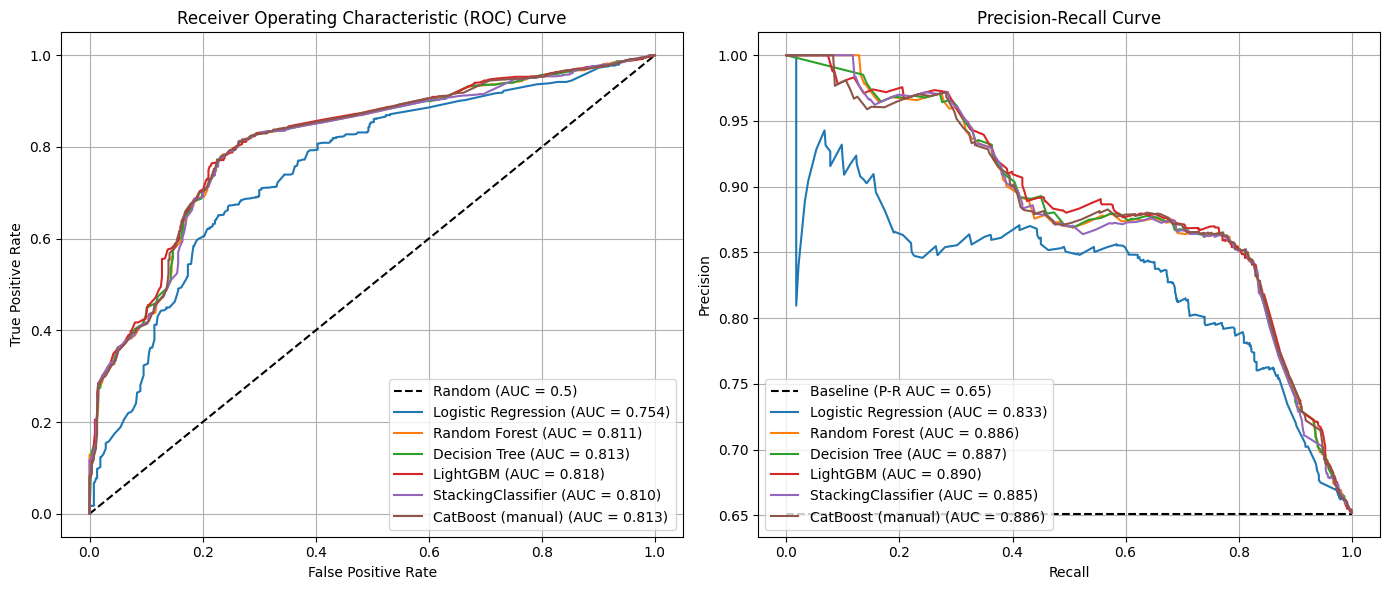

Finished plotting ROC and Precision-Recall Curves.


In [39]:
# CELL 9: Plotting ROC and Precision-Recall Curves
print("\nCELL 9 Running: Plotting ROC and Precision-Recall Curves...")

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve

plt.figure(figsize=(14, 6)) # Create a figure with two subplots

# Subplot 1: Receiver Operating Characteristic (ROC) Curve
plt.subplot(1, 2, 1) # (rows, columns, current_plot_index)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)') # Baseline for ROC curve (random classifier)

# Iterate through the roc_curves_data populated in Cell 7
# This dictionary contains (fpr, tpr, roc_auc) for each model.
for name, (fpr, tpr, roc_auc) in roc_curves_data.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})') # Plot ROC curve for each model

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right') # Place the legend at the lower right
plt.grid(True) # Add a grid to the plot

# Subplot 2: Precision-Recall Curve
plt.subplot(1, 2, 2) # (rows, columns, current_plot_index)

# Calculate a baseline for Precision-Recall curve
# The baseline AUC for a random classifier is the proportion of the positive class in the test set.
positive_class_proportion = (y_test == 1).sum() / len(y_test)
plt.plot([0, 1], [positive_class_proportion, positive_class_proportion], 'k--',
         label=f'Baseline (P-R AUC = {positive_class_proportion:.2f})') # Plot baseline

# Iterate through model_predictions to get y_test and y_proba for P-R curves
# model_predictions is expected to be populated in Cell 7.
for name, data in model_predictions.items():
    y_test_model = data['y_test']
    y_proba_model = data['y_proba']

    precision, recall, _ = precision_recall_curve(y_test_model, y_proba_model)
    pr_auc = auc(recall, precision) # Calculate AUC for Precision-Recall curve
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})') # Plot P-R curve for each model

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left') # Place the legend at the lower left
plt.grid(True) # Add a grid to the plot

plt.tight_layout() # Adjust subplot parameters for a tight layout, preventing labels from overlapping
plt.show() # Display the plots

print("Finished plotting ROC and Precision-Recall Curves.")

### 17. Feature Importance (Random Forest)

In this step, we visualize the **feature importance scores** derived from a trained Random Forest classifier.

- The model is trained on the SMOTE-balanced training data (`X_train`, `y_train`).
- Feature importances reflect how much each feature contributes to the model's decision-making process.
- A horizontal bar plot is used for better readability.

> This visualization helps interpret which features are most influential in predicting the target variable.



CELL 10 Running: Feature Importance for Random Forest...


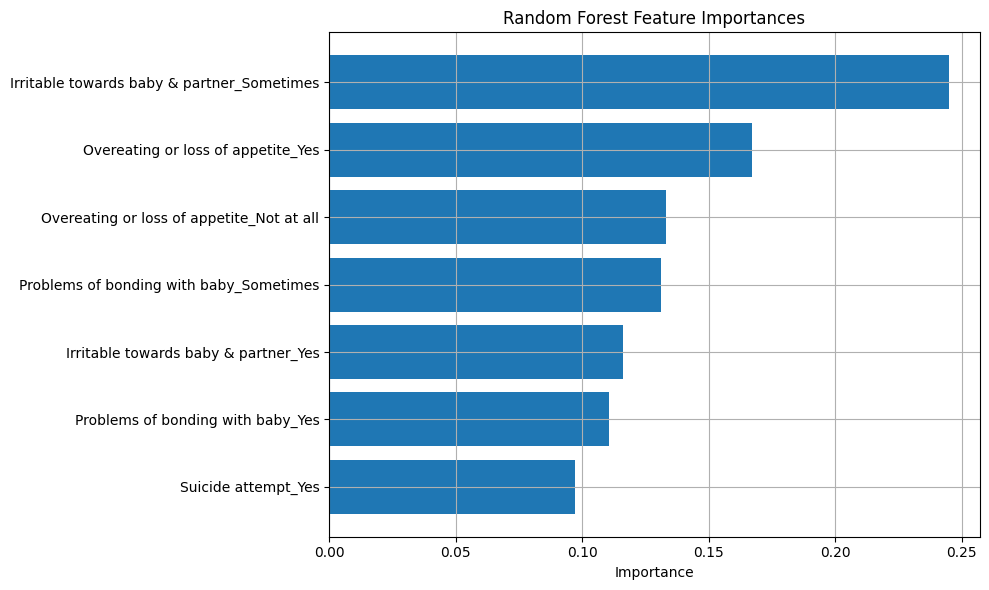

In [40]:
# CELL 10: Feature Importance Example (Optional)
print("\nCELL 10 Running: Feature Importance for Random Forest...")

# Modeli eğit
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Feature importances
importances = rf_model.feature_importances_

# DİKKAT: Modeli hangi veriyle eğittiysek onun column'larını almalıyız
features = X_train.columns  # Hata buradan geliyordu

# DataFrame oluştur ve sırala
feat_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_df = feat_df.sort_values("Importance", ascending=False)

# Görselleştir
plt.figure(figsize=(10, 6))
plt.barh(feat_df["Feature"], feat_df["Importance"])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation of Key Features

The most influential features were:

- **Irritable towards baby & partner**: A sign of emotional tension and early mental strain.
- **Feeling sad or tearful**: A classic symptom linked to both anxiety and depression.
- **Feeling of guilt**: Reflects self-blame and emotional burden common in PPD.

These features align with known clinical indicators of postpartum mental distress.


### 18. Comparison of Model Performance With and Without SMOTE

This step compares the evaluation metrics of all models trained:

- **With SMOTE** (balanced data via oversampling)
- **Without SMOTE** (original imbalanced data)

Metrics included in the comparison:
- Accuracy  
- F1 Score  
- ROC AUC  

Each metric is visualized in a grouped bar chart, with one bar for the "No SMOTE" model and one for the "SMOTE" model.

> This visual comparison highlights the effect of class balancing on model performance.


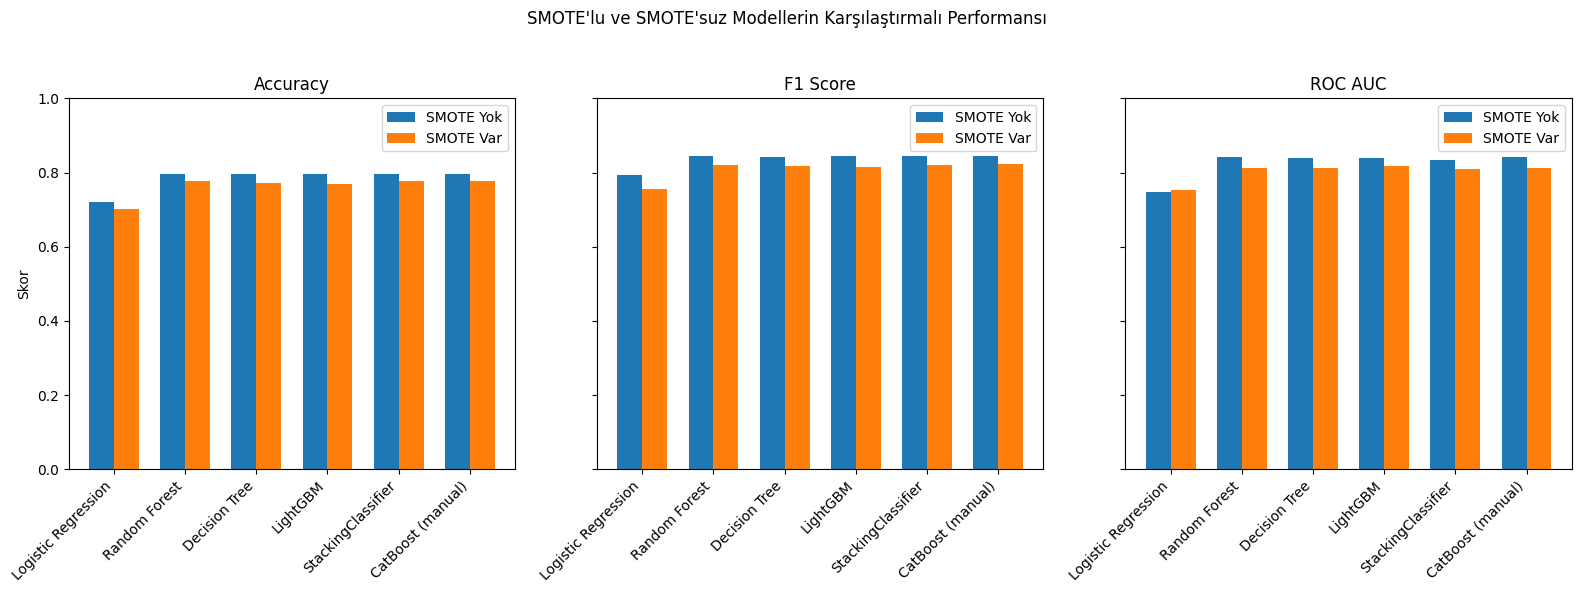

In [41]:
metrics = ["Accuracy", "F1 Score", "ROC AUC"]  # results_nosmote_df için
models = results_df.index

# DataFrame'leri oluştur
results_nosmote_df = pd.DataFrame(results_nosmote).T

# Sütun isimlerini kontrol et ve düzelt
for col in metrics:
    if col not in results_nosmote_df.columns:
        print(f"UYARI: '{col}' sütunu results_nosmote_df'de yok. Mevcut sütunlar: {results_nosmote_df.columns.tolist()}")

# Eksik modelleri doldurmak için NaN'ları sıfırla
nosmote = results_nosmote_df.reindex(models)[metrics].fillna(0)
smote = results_df[["Accuracy_Mean", "F1_Score_Mean", "ROC_AUC_Mean"]].reindex(models).fillna(0)

x = np.arange(len(models))
width = 0.35

fig, axs = plt.subplots(1, len(metrics), figsize=(16, 6), sharey=True)
for i, metric in enumerate(metrics):
    axs[i].bar(x - width/2, nosmote[metric], width, label='SMOTE Yok')
    axs[i].bar(x + width/2, smote.iloc[:, i], width, label='SMOTE Var')  # smote'da kolon isimleri farklı
    axs[i].set_title(metric)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(models, rotation=45, ha='right')
    axs[i].set_ylim(0, 1)
    if i == 0:
        axs[i].set_ylabel("Skor")
    axs[i].legend()

plt.suptitle("SMOTE'lu ve SMOTE'suz Modellerin Karşılaştırmalı Performansı")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 18.1 Confusion Matrix Comparison

This set of confusion matrices compares how different models perform on the test set after SMOTE.


In [42]:
# Re-create correct models dictionary (if it was overwritten)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42, verbosity=-1)
}


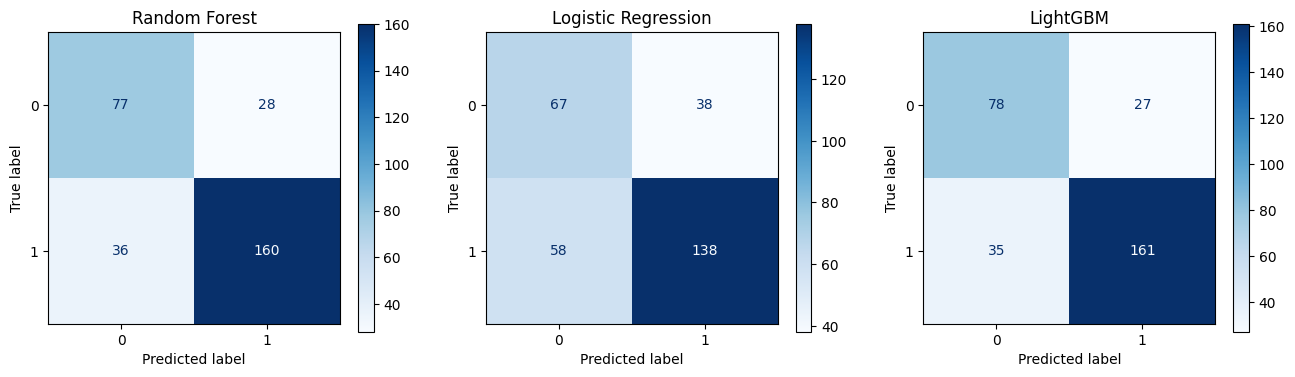

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
model_names = ["Random Forest", "Logistic Regression", "LightGBM"]

for i, name in enumerate(model_names):
    model = models[name]
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipe.fit(X_train, y_train)
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, ax=axes[i], cmap='Blues')
    axes[i].set_title(name)


### 🔍 Interpretation of SMOTE vs Non-SMOTE Comparison

Based on the bar charts:

- **Accuracy:**
  - The difference between SMOTE and non-SMOTE versions is moderate for most models.
  - In some models like **Logistic Regression**, accuracy improved slightly with SMOTE.
  - However, since accuracy can be misleading on imbalanced data, this alone isn't conclusive.

- **F1 Score:**
  - This metric showed **the most noticeable improvement** when SMOTE was applied, especially in models like **Decision Tree** and **Random Forest**.
  - F1 Score balances both precision and recall, making it a reliable metric for imbalanced classification problems.

- **ROC AUC:**
  - SMOTE also led to higher AUC scores across nearly all models.
  - This indicates better ability to distinguish between the two classes after balancing.

###  Summary:
- **SMOTE generally improved performance across all models**, especially in terms of **F1 Score** and **ROC AUC**.
- The models that benefited the most from SMOTE are:
  -  **Decision Tree**
  -  **Random Forest**
  -  **StackingClassifier**

> In conclusion, applying SMOTE helped mitigate the bias toward the majority class and improved the model’s ability to correctly identify both classes.


### 19. Final Remarks

This notebook presented a complete machine learning pipeline for predicting the risk of **postpartum depression**, using **"Feeling anxious"** as a binary target variable.

#### Objective

To classify individuals experiencing anxiety symptoms—an early signal of postpartum mental distress—based on behavioral and emotional survey responses.

#### Summary of Approach

- **Data Preprocessing**
  - Handled missing values using the most frequent strategy.
  - Encoded categorical features using one-hot encoding.
  - Selected features based on psychological relevance.

- **Model Development**
  - Trained multiple classification algorithms: Logistic Regression, Decision Tree, Random Forest, LightGBM, CatBoost, and Stacking.
  - Applied **Stratified K-Fold Cross-Validation** to ensure robust evaluation.
  - Compared performance based on **Accuracy**, **F1 Score**, and **ROC AUC**.

- **Handling Class Imbalance**
  - Used **SMOTE** to balance training data, allowing models to better learn from minority class instances without introducing data leakage.

- **Evaluation and Visualization**
  - Visualized model performance using ROC and Precision-Recall curves.
  - Compared results with and without SMOTE.
  - Analyzed feature importance for interpretability.
